# MiDAS Depth estimation 

Note-  DO NOT try to pip install midas.  The midas on pip is a totally different library (unrelated to image processing) and it will cause issues with this code

This runs MiDAS through PyTorch (MiDAS is part of the pytorch hub so you don't need a seperate install).  You will probably need to 'pip install timm' 


In [1]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

# Triggers fresh download of MiDaS repo
#torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  


In [2]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /Users/theodorehuppert/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/theodorehuppert/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()



MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/theodorehuppert/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
# Grab one of the default images from pytorch
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [6]:

input_batch = transform(img).to(device)

with torch.no_grad():  # This prevents the model from updating (prediction only)
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Text(0.5, 1.0, 'Depth Map')

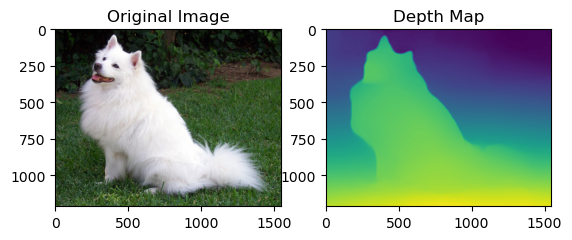

In [7]:
plt.subplot(121); plt.imshow(img); plt.title('Original Image')
plt.subplot(122); plt.imshow(output); plt.title('Depth Map')
